In [1]:
import sys
import subprocess
print(subprocess.check_output([sys.executable, "-m", "pip", "install", "numpy", 
                                                                       "scipy",
                                                                       "tqdm",
                                                                       "matplotlib",
                                                                       "sklearn"]).decode('utf-8'))

In [2]:
import math

from copy import copy
from random import random
from tqdm import tqdm

import numpy as np
import scipy as sp

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from sklearn.datasets import load_digits
digits = load_digits()

In [4]:
EPS = 1e-3

def curve(x, a, b):
    return 1.0 / (1.0 + a * x ** (2.0 * b))
    

def attractive_force(dist_sq, a, b):
    if dist_sq > 0.0:
        result = -2.0 * a * b * pow(dist_sq, b - 1.0)
        result /= a * pow(dist_sq, b) + 1.0
    else:
        result = 0.0
    return result


def repilsive_force(dist_sq, a, b):
    result = 2.0 * b
    result /= (EPS + dist_sq) * (
        a * pow(dist_sq, b) + 1
    )
    return result


In [5]:
def find_ab_params(min_dist):
    xv = np.linspace(0.0, 3.0, 300)
    yv = np.zeros(xv.shape)
    yv[xv < min_dist] = 1.0
    yv[xv >= min_dist] = np.exp(-(xv[xv >= min_dist] - min_dist))
    params, covar = sp.optimize.curve_fit(curve, xv, yv)
    return params[0], params[1]

In [6]:
def smooth_single_dist(knn_dist):
    sigma_lower = 0.0
    sigma_upper = None
    sigma = 1.0

    target = np.log2(len(knn_dist))
    while sigma_upper is None or sigma_upper - sigma_lower > EPS:
        if sigma > target:
            sigma_upper = sigma
        else:
            sigma_lower = sigma

        if sigma_upper is None:
            sigma *= 2.0
        else:
            sigma = (sigma_lower + sigma_upper) / 2.0

    non_zero_dist = knn_dist[knn_dist > 0]
    if len(non_zero_dist) > 0:
        rho = non_zero_dist[0]
    else:
        rho = EPS

    return sigma, rho

def smooth_dists(knn_dists):
    sigmas = np.zeros(len(knn_dists), dtype=np.float32)
    rhos = np.zeros(len(knn_dists), dtype=np.float32)

    for i, knn_dist in enumerate(knn_dists):
        sigmas[i], rhos[i] = smooth_single_dist(knn_dists)

    return sigmas, rhos

In [7]:
class Umap(object):
    
    def __init__(self, n_neighbors=15, target_dim=2, min_dist=0.1, n_epochs=100):
        self.n_neighbors = n_neighbors
        self.target_dim = target_dim
        self.n_epochs = n_epochs
        self.a, self.b = find_ab_params(min_dist)
    
    def fit_transform(self, X):
        graph = self._build_graph(X)

        Y = self._build_embedding(graph)
        Y = self._optimize_embedding(graph, Y)
        return Y
    
    def _sdist(self, x_i, x_j):
        return sp.spatial.distance.euclidean(x_i, x_j)

    def _tdist(self, y_i, y_j):
        return sp.spatial.distance.euclidean(y_i, y_j) ** 2
    
    def _find_neighbors(self, X):
        idxs = np.zeros((len(X), self.n_neighbors), dtype=np.int32)
        dists = np.zeros((len(X), self.n_neighbors), dtype=np.float32)

        for i, x_i in tqdm(enumerate(X)):
            dists_i = np.zeros(len(X), dtype=np.float32)
            for j, x_j in enumerate(X):
                if i == j:
                    continue

                dists_i[j] = self._sdist(x_i, x_j)
                idxs[i] = np.argsort(dists_i)[1 : self.n_neighbors + 1]
            dists[i] = dists_i[idxs[i]]

        return idxs, dists

    def _build_graph(self, X):
        knn_idxs, knn_dists = self._find_neighbors(X)
        sigmas, rhos = smooth_dists(knn_dists)

        rows = np.zeros(len(X) * self.n_neighbors, dtype=np.int32)
        cols = np.zeros(len(X) * self.n_neighbors, dtype=np.int32)
        vals = np.zeros(len(X) * self.n_neighbors, dtype=np.float32)

        for i in tqdm(range(len(X))):
            for j in range(self.n_neighbors):
                if knn_idxs[i][j] == -1 or knn_idxs[i][j] == i:
                    continue

                if knn_dists[i][j] - rhos[i] <= 0.0 or sigmas[i] == 0.0:
                    val = 1.0
                else:
                    val = np.exp(-((knn_dists[i][j] - rhos[i]) / (sigmas[i])))

                rows[i * self.n_neighbors + j] = i
                cols[i * self.n_neighbors + j] = knn_idxs[i][j]
                vals[i * self.n_neighbors + j] = val

        graph = sp.sparse.coo_matrix(
            (vals, (rows, cols)), shape=(len(X), len(X))
        )
        return graph

    def _build_embedding(self, graph):
        diag = np.asarray(graph.sum(axis=0))

        I = sp.sparse.identity(graph.shape[0], dtype=np.float64)
        D = sp.sparse.spdiags(
            1.0 / np.sqrt(diag), [0], graph.shape[0], graph.shape[0]
        )
        L = I - D * graph * D

        dim = self.target_dim + 1
        e_vals, e_vecs = sp.sparse.linalg.eigsh(L, dim)

        order = np.argsort(e_vals)[1:dim]
        return e_vecs[:, order]

    def _optimize_embedding(self, graph, Y):
        alpha = 1.0
        for e in tqdm(range(self.n_epochs)):

            for (i, j, v) in zip(graph.row, graph.col, graph.data):
                if random() < v:
                    force = attractive_force(self._tdist(Y[i], Y[j]), self.a, self.b)
                    Y[i] += alpha * force * (Y[i] - Y[j])

                    neg_idxs = np.random.choice(graph.shape[0], 5)
                    for k in neg_idxs:
                        force = repilsive_force(self._tdist(Y[i], Y[k]), self.a, self.b)
                        Y[i] += alpha * force * (Y[i] - Y[k])

            alpha = 1.0 - e / self.n_epochs

        return Y


In [8]:
reducer = Umap()
embedding = reducer.fit_transform(digits.data)
embedding.shape

1797it [03:16,  9.13it/s]
100%|██████████| 1797/1797 [00:00<00:00, 6442.27it/s]
<ipython-input-7-6b5d312ad6e8>:70: RuntimeWarning: divide by zero encountered in true_divide
  1.0 / np.sqrt(diag), [0], graph.shape[0], graph.shape[0]
100%|██████████| 100/100 [03:11<00:00,  1.92s/it]


(1797, 2)

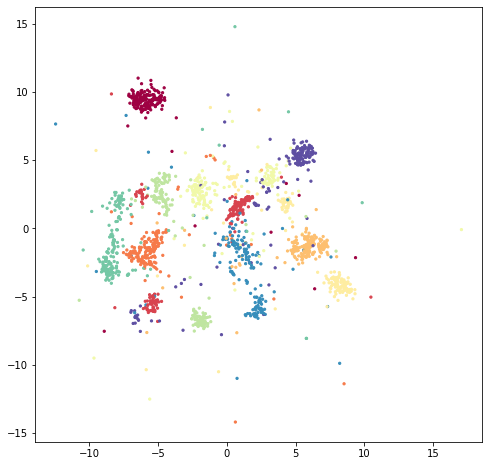

In [9]:
plt.figure(figsize=(8,8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=digits.target, cmap='Spectral', s=5)
plt.show()